<a href="https://colab.research.google.com/github/markusloecher/DataScience2021/blob/main/TWSM/Class2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMD Movie Reviews


***Loading the IMDB dataset***

In [55]:
import re
import pandas as pd
import numpy as np
# Import packages
import pandas as pd
import re
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
import pickle
import en_core_web_sm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import Binarizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svawe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000) #removes all words that are not among the 10000 most common words

**Decoding reviews back to text**

In [10]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [86]:
N=len(train_data)
decoded_reviews = ["" for x in range(N)]

for j in range(N):
    decoded_reviews[j] = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[j]])

In [14]:
def tf(text):
    text = text.lower()
    text = remove_stopwords(text)
    text = strip_punctuation(text)
    text = strip_tags(text)
    text = strip_numeric(text)
    text = strip_multiple_whitespaces(text)
    text = strip_short(text)
    text_split = text.split()
    wordlist = np.unique(text_split, return_counts= True)
    df = pd.DataFrame(wordlist).transpose()
    df.columns = ["word","frequency"]
    df = df.sort_values("frequency", ascending = False)
    df.reset_index(inplace = True)
    df = df.drop(columns = "index")
    df["frequency"] = df["frequency"].astype(int)
    return df

bing = pd.read_csv(r"C:\Users\svawe\Downloads\SentimentDictionaries\bing.csv").drop(columns = ["Unnamed: 0"])

### Tasks

Build a classifier on the train data in at least five different ways:

1. using sentiment analysis
2. using term frequencies in at least **4** different flavors. 
The data set in 2. is VERY high-dimensional so please choose a classifier that can deal with feature selection.

#### Sentiment analysis

In [29]:
%%time
sentiments = []
for i in decoded_reviews:
    loop_df = tf(i)
    sentiment = loop_df.merge(bing, how = "inner", on = "word")
    senti_map = {"negative" : -1, "positive": 1}
    sentiment["sentiment"] = sentiment["sentiment"].map(senti_map)
    sentiment["sentiment_weighed"] = sentiment["frequency"] * sentiment["sentiment"]
    sentiments.append(np.sum(sentiment.sentiment_weighed))

Wall time: 2min 51s


<AxesSubplot:xlabel='truth', ylabel='sent_score'>

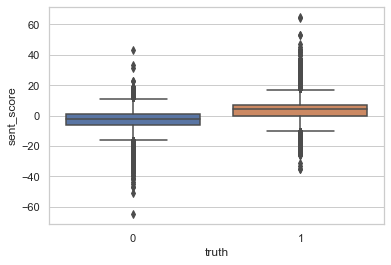

In [35]:
sentiments_truth = list(zip(sentiments, train_labels))
sent_df = pd.DataFrame(sentiments_truth, columns = ["sent_score","truth"])
sns.boxplot(data = sent_df, x = "truth", y = "sent_score")
#this does not seem very precise

In [43]:
sent_df["pred"] = 0
for i in range(sent_df.shape[0]):
    if sent_df.sent_score[i] >= 0: sent_df["pred"][i] = 1

In [50]:
confusion_matrix(sent_df.truth, sent_df.pred), accuracy_score(sent_df.truth, sent_df.pred)

(array([[ 8069,  4431],
        [ 2397, 10103]], dtype=int64),
 0.72688)

0.4.1.2 10000x1 Matrix
- based on absolute term frequency -> problem: document length varies
- overall occurance (OHE) -> problem: ignores how often words are used
- based on relative term frequency -> idenpendent of document length
- weighted term frequency -> commonly used words should be weighed less (because they will not be unique to positive or negative outcome) -> weighing based on Document Frequency ("in how many documents does this word occur") -> divide occurence in document by document frequency (problem: very unique words that occur often in a single data point are boosted too much (such as name of the movie etc.) -> regularize it! (smoothed)) OR use freq(word) * log(inverse document frequency)

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [99]:
full_data = list(train_data)
for i in test_data:
    full_data.append(i)
len(full_data)

50000

In [100]:
N=len(full_data)
dec_reviews = ["" for x in range(N)]
for j in range(N):
    dec_reviews[j] = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in full_data[j]])

In [101]:
%%time
absolute_vect = CountVectorizer(max_df = 0.95, min_df = 0.01)
absolute = absolute_vect.fit_transform(dec_reviews)
absolute_train = absolute[:25000]
absolute_test = absolute[25000:]
relative_vect = TfidfVectorizer(max_df = 0.95, min_df = 0.01, use_idf = False, norm = "l1")
relative = relative_vect.fit_transform(dec_reviews)
relative_train = relative[:25000]
relative_test = relative[25000:]
idf_vect = TfidfVectorizer(max_df = 0.95, min_df = 0.01, smooth_idf = False)
idf = idf_vect.fit_transform(dec_reviews)
idf_train = idf[:25000]
idf_test = idf[25000:]
OHE_train = Binarizer().fit_transform(absolute_train)
OHE_test = Binarizer().fit_transform(absolute_test)

Wall time: 20.8 s


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [126]:
%%time
rf_clf = RandomForestClassifier()
logit = LogisticRegression()
ridge_clf = RidgeClassifier()

classifiers = [["rf", rf_clf],["logistic", logit], ["ridge",ridge_clf]]
data = [["OHE", OHE_train, OHE_test],["absolute", absolute_train, absolute_test],["relative", relative_train, relative_test], ["idf", idf_train, idf_test]]
results = []
for i in classifiers:
    for j in data:
        i[1].fit(j[1], train_labels)
        results.append([i[0], j[0], accuracy_score(test_labels, i[1].predict(j[2]))])

C:\Users\svawe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\svawe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Wall time: 5min 2s


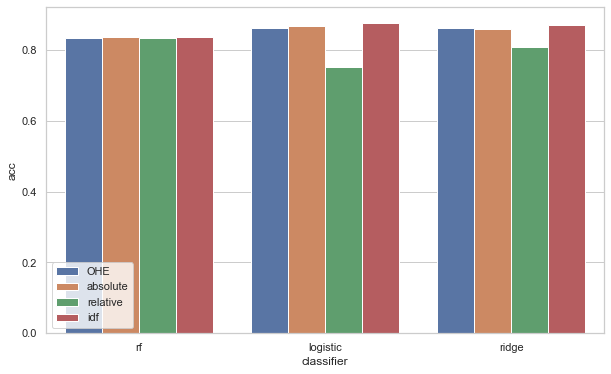

In [143]:
results = pd.DataFrame(results, columns = ["classifier","encoding","acc"])
ax, fig = plt.subplots(figsize = (10,6))
sns.barplot(data = results, y = "acc", x = "classifier", hue = "encoding")
plt.legend(loc = "lower left")

In [149]:
def max_row(group):
    return group.loc[group['acc'] == group['acc'].max()]
results.groupby('classifier', as_index=False).apply(max_row).reset_index(drop=True)

,classifier,encoding,acc
0,logistic,idf,0.87760
1,rf,absolute,0.83696
2,ridge,idf,0.87156


In [184]:
#Does further preproccesing increase the acc?
data_stem = []
for i in dec_reviews:
    text = i.lower() #remove upper case letters to allow grouping
    text = remove_stopwords(text)
    text = strip_punctuation(text) #remove all instances of . and : 
    text = strip_tags(text)
    text = strip_numeric(text) #remove all numbers (because uninterpretable, i guess)
    text = strip_multiple_whitespaces(text) #remove dupplicate spaces
    text = strip_short(text)
    data_stem.append(stem_text(text)) 

In [185]:
data_stem[0]

'film brilliant cast locat sceneri stori direct everyon suit plai imagin robert amaz actor director father came scottish island love fact real connect film witti remark film great brilliant bought film soon releas recommend watch fly fish amaz cri end sad know film good definit littl boi plai norman paul brilliant children left list think star plai grown big profil film children amaz prais don think stori love true someon life share'

In [366]:
absolute_vect = CountVectorizer(max_df = 0.95, min_df = 0.01)
absolute_stem = absolute_vect.fit_transform(data_stem)
absolute_stem_train = absolute_stem[:25000]
absolute_stem_test = absolute_stem[25000:]
relative_vect = TfidfVectorizer(max_df = 0.95, min_df = 0.01, use_idf = False, norm = "l1")
relative_stem = relative_vect.fit_transform(data_stem)
relative_stem_train = relative_stem[:25000]
relative_stem_test = relative_stem[25000:]
idf_vect = TfidfVectorizer(max_df = 0.95, min_df = 0.01, smooth_idf = False)
idf_stem = idf_vect.fit_transform(data_stem)
idf_stem_train = idf_stem[:25000]
idf_stem_test = idf_stem[25000:]
OHE_stem_train = Binarizer().fit_transform(absolute_train)
OHE_stem_test = Binarizer().fit_transform(absolute_test)

In [367]:
%%time
rf_clf = RandomForestClassifier()
logit = LogisticRegression()
ridge_clf = RidgeClassifier()

classifiers = [["rf", rf_clf],["logistic", logit], ["ridge",ridge_clf]]
data = [["OHE", OHE_stem_train, OHE_stem_test],["absolute", absolute_stem_train, absolute_stem_test],["relative", relative_stem_train, relative_stem_test], ["idf", idf_stem_train, idf_stem_test]]
results_stem = []
for i in classifiers:
    for j in data:
        i[1].fit(j[1], train_labels)
        results_stem.append([i[0], j[0], accuracy_score(test_labels, i[1].predict(j[2]))])

C:\Users\svawe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\svawe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Wall time: 4min 33s


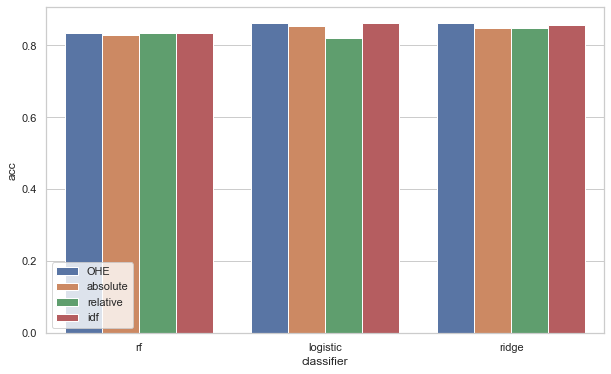

In [368]:
results_stem = pd.DataFrame(results_stem, columns = ["classifier","encoding","acc"])
ax, fig = plt.subplots(figsize = (10,6))
sns.barplot(data = results_stem, y = "acc", x = "classifier", hue = "encoding")
plt.legend(loc = "lower left")

In [370]:
def max_row(group):
    return group.loc[group['acc'] == group['acc'].max()]
results_stem.groupby('classifier', as_index=False).apply(max_row).reset_index(drop=True)
#actually reduced the accuracy!

,classifier,encoding,acc
0,logistic,OHE,0.86352
1,rf,relative,0.83416
2,ridge,OHE,0.86264


## Bigrams

In [163]:
%%time
ngram_vect = CountVectorizer(ngram_range = (2,4), max_df = 0.95, min_df = 0.001)
review_vect = ngram_vect.fit_transform(dec_reviews)

Wall time: 57 s


In [164]:
ngrams = ngram_vect.get_feature_names_out()

In [165]:
ngrams_not = []
for i in ngrams:
    if i.count("not") > 0: ngrams_not.append(i)

In [197]:
notgrams = [re.findall("^not .*", i) for i in ngrams_not]
notgrams = list(filter(None, notgrams))

In [302]:
df_full = pd.DataFrame(absolute.toarray())
#add empty columns for every not-gram in our list
df_full_long = df_full.reindex(columns = np.arange(0,(df_full.shape[1] + len(notgrams))))
mapper = list(zip(df_full_long.columns[1783:],np.arange(0,294)))

In [305]:
#add absolute counts for the respective not-gram
for i in dec_reviews:
    a = dec_reviews.index(i)
    for index_df, index_notgram in mapper:
        df_full_long[index_df][a] = i.count(notgrams[index_notgram][0])

C:\Users\svawe\AppData\Local\Temp/ipykernel_13824/4223606391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_long[index_df][a] = i.count(notgrams[index_notgram][0])


In [362]:
#weirdly there are some nan values in the df
#df_full_long[df_full_long.isna().any(axis=1)]
df_full_long.fillna(0, inplace = True)
X_train = df_full_long.iloc[:25000]
X_test = df_full_long.iloc[25000:]

In [364]:
rf_clf = RandomForestClassifier()
logit = LogisticRegression()
ridge_clf = RidgeClassifier()

rf_clf.fit(X_train, train_labels)
logit.fit(X_train, train_labels)
ridge_clf.fit(X_train, train_labels)
accuracy_score(test_labels, rf_clf.predict(X_test)),accuracy_score(test_labels, logit.predict(X_test)),accuracy_score(test_labels, ridge_clf.predict(X_test)) 
#putting the not-grams in the prediction did not increase accuracy!

C:\Users\svawe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8348, 0.86992, 0.86132)

In [365]:
results_stem[results_stem["encoding"] == "absolute"]

,classifier,encoding,acc
1,rf,absolute,0.83704
5,logistic,absolute,0.86840
9,ridge,absolute,0.86008
